<a href="https://colab.research.google.com/github/prikshit-2000/Tensorflow/blob/main/Energy_Efficient.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [28]:
import tensorflow as tf
from tensorflow.keras.layers import Dense
from tensorflow.keras import Input
from tensorflow.keras.models import Model
import numpy as np
import matplotlib.pyplot as plt
import pydot
import pandas as pd
from tensorflow.python.keras.utils.vis_utils import plot_model
from sklearn.model_selection import  train_test_split

In [29]:
def format_output(data):
    y1 = data.pop('Y1')
    y1 = np.array(y1)
    y2 = data.pop('Y2')
    y2 = np.array(y2)

    return y1,y2

def norm(x):
    return (x-train_stats['mean'])/train_stats['std']

def plot_diff(y_true , y_pred , title =''):
    plt.scatter(y_true , y_pred)
    plt.title(title)
    plt.xlabel('True Labels')
    plt.ylabel('Predictions')
    plt.axis('equal')
    plt.axis('square')
    plt.xlim(plt.xlim())
    plt.ylim(plt.ylim())
    plt.plot([-100,100],[-100,100])
    plt.show()

def plot_metrics(metric_name , title,ylim = 5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name], color = 'blue',label = metric_name)
    plt.plot(history.history['val_' + metric_name] , color = 'green' , label  = 'val_'+metric_name)
    plt.show()

In [30]:
URL = "https://archive.ics.uci.edu/ml/machine-learning-databases/00242/ENB2012_data.xlsx"
df = pd.read_excel(URL)
df = df.sample(frac = 1).reset_index(drop = True)

train,test = train_test_split(df,test_size = 0.2)
train_stats = train.describe()

train_stats.pop('Y1')
train_stats.pop('Y2')
train_stats = train_stats.transpose()
train_Y = format_output(train)
test_Y =  format_output(test)

norm_train_X = norm(train)
norm_test_X = norm(test)

In [31]:
input_layer = Input(shape = (len(train.columns),))
first_dense = Dense(128 , activation = 'relu')(input_layer)
second_dense = Dense(128 , activation = 'relu')(first_dense)

y1_output = Dense(1 , name = 'y1_output')(second_dense)

third_dense = Dense(64 , activation = 'relu')(second_dense)
y2_output = Dense(1, name = 'y2_output')(third_dense)

model = Model(inputs = input_layer,outputs = [y1_output , y2_output])
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 8)]          0                                            
__________________________________________________________________________________________________
dense_6 (Dense)                 (None, 128)          1152        input_3[0][0]                    
__________________________________________________________________________________________________
dense_7 (Dense)                 (None, 128)          16512       dense_6[0][0]                    
__________________________________________________________________________________________________
dense_8 (Dense)                 (None, 64)           8256        dense_7[0][0]                    
____________________________________________________________________________________________

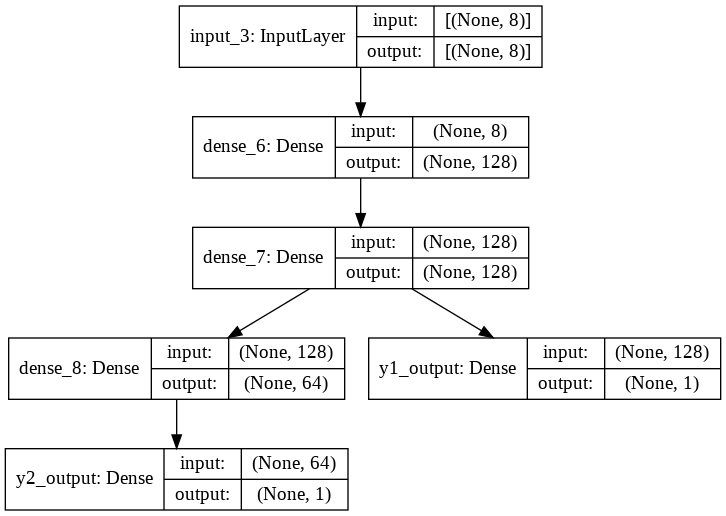

In [39]:
optimizer = tf.keras.optimizers.SGD(learning_rate=  0.001)
model.compile(optimizer=optimizer , 
              loss = {'y1_output':'mse','y2_output':'mse'},
              metrics = {'y1_output':tf.keras.metrics.RootMeanSquaredError(),'y2_output':tf.keras.metrics.RootMeanSquaredError()})
from tensorflow.keras.layers import Layer
# model._layers = [
#                  layer for layer in model._layers if isinstance(layer,Layer)

# ]
plot_model(model)
plot_model(model,show_shapes = True , show_layer_names= True , to_file= 'model.png')



In [40]:
history = model.fit(norm_train_X,train_Y,
                    epochs = 2000,batch_size = 10 , validation_data = (norm_test_X,test_Y))
loss , Y1_loss , Y2_loss , Y1_rmse  , Y2_rmse = model.evaluate(x = norm_test_X , y = test_Y)
print("Loss = {} , Y1_loss = {} , Y2_loss = {} , Y1_rmse = {} , Y2_rmse = {}".format(loss , Y1_loss , Y2_loss , Y1_rmse  , Y2_rmse))

Epoch 1/2000
62/62 [==============================] - 2s 8ms/step - loss: 254.9507 - y1_output_loss: 117.3721 - y2_output_loss: 137.5785 - y1_output_root_mean_squared_error: 10.8338 - y2_output_root_mean_squared_error: 11.7294 - val_loss: 62.1085 - val_y1_output_loss: 22.5717 - val_y2_output_loss: 39.5368 - val_y1_output_root_mean_squared_error: 4.7510 - val_y2_output_root_mean_squared_error: 6.2878
Epoch 2/2000
62/62 [==============================] - 0s 2ms/step - loss: 32.6377 - y1_output_loss: 12.9127 - y2_output_loss: 19.7249 - y1_output_root_mean_squared_error: 3.5934 - y2_output_root_mean_squared_error: 4.4413 - val_loss: 23.6003 - val_y1_output_loss: 10.6593 - val_y2_output_loss: 12.9410 - val_y1_output_root_mean_squared_error: 3.2649 - val_y2_output_root_mean_squared_error: 3.5974
Epoch 3/2000
62/62 [==============================] - 0s 3ms/step - loss: 26.8386 - y1_output_loss: 10.1026 - y2_output_loss: 16.7360 - y1_output_root_mean_squared_error: 3.1785 - y2_output_root_mean

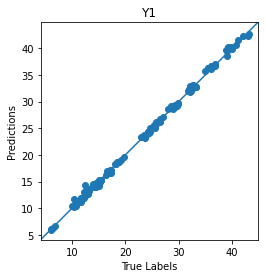

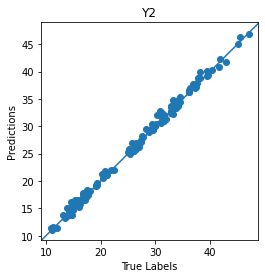

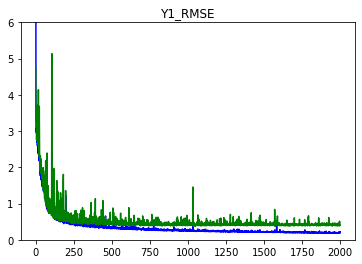

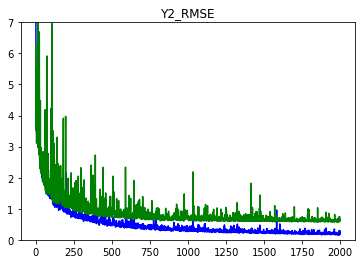

In [41]:
Y_pred  = model.predict(norm_test_X)
plot_diff(test_Y[0], Y_pred[0],title = 'Y1')
plot_diff(test_Y[1], Y_pred[1],title = 'Y2')
plot_metrics(metric_name = 'y1_output_root_mean_squared_error' ,title = 'Y1_RMSE' ,  ylim = 6  )
plot_metrics(metric_name = 'y2_output_root_mean_squared_error' ,title = 'Y2_RMSE' ,  ylim = 7  )